In [1]:
import warnings;
warnings.simplefilter('ignore')

In [2]:
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
import orca
import os; os.chdir('../')

import pandas as pd
import numpy as np

from scripts import datasources
from scripts import models
from scripts import variables

/home/juan/anaconda3/envs/template-env/lib/python3.6/site-packages/pandana/network.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/juan/anaconda3/envs/template-env/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/juan/anaconda3/envs/template-env/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/juan/anaconda3/envs/template-env/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/juan/anaconda3/envs/template-env/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/juan/anaconda

Registering model step 'auto_ownership'
Registering model step 'TOD_choice'
Registering model step 'primary_mode_choice'
Registering model step 'WLCM'


In [3]:
# mm.initialize()

## Generating accesibility variables

In [4]:
orca.run(['initialize_network_small', 'network_aggregations_small'])

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'network_aggregations_small'
Computing accessibility variables
Computing units_10000
Computing units_sf_10000
Computing units_mf_10000
Computing pop_10000
Removed 189769 rows because they contain missing values
Computing hh_10000
Removed 189769 rows because they contain missing values
Computing poor_10000
Removed 53114 rows because they contain missing values
Computing renters_10000
Removed 102597 rows because they contain missing values
Computing avg_income_10000
Removed 189769 rows because they contain missing values
Computing jobs_10000
Computing avg_rent_10000
Computing med_rent_10000
Computing pop_white_10000
Removed 107372 rows because they contain missing values
Computing pop_black_10000
Removed 10541 rows because they contain missing values
Computing pop_asian_10000
Removed 51048 rows because they contain missing values
Computing pop_hisp_10000
Removed 31685 rows because

In [5]:
orca.run(['initialize_network_walk', 'network_aggregations_walk'])

Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Running step 'network_aggregations_walk'
Computing accessibility variables
Computing units_500_walk
Computing sqft_unit_500_walk
Computing singles_500_walk
Removed 52084 rows because they contain missing values
Computing elderly_hh_500_walk
Removed 34553 rows because they contain missing values
Computing children_500_walk
Removed 189769 rows because they contain missing values
Computing units_sf_500_walk
Computing units_mf_500_walk
Computing pop_500_walk
Removed 189769 rows because they contain missing values
Computing hh_500_walk
Removed 189769 rows because they contain missing values
Computing poor_500_walk
Removed 53114 rows because they contain missing values
Computing rich_500_walk
Removed 38964 rows because they contain missing values
Computing renters_500_walk
Removed 102597 rows because they contain missing values
Computing avg_income_500_walk
Removed 189769 rows because they contain m

## Loading data

In [200]:
#Loading am peak transit accessibility varaibles
@orca.table(cache=False)
def am_acc():
    df = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
    df.block_id = df.block_id.str.zfill(15)
    return df

households = orca.get_table('households').to_frame()
persons = orca.get_table('persons').to_frame()
parcels = orca.get_table('parcels').to_frame()
nodessmall = orca.get_table('nodessmall').to_frame()
# nodessmall = pd.read_csv('/home/data/2018-07/nodessmall_vars.csv')
nodessmall.index.name = 'node_id_small'
nodeswalk = orca.get_table('nodeswalk').to_frame()
# nodeswalk = pd.read_csv('/home/data/2018-07/nodeswalk_vars.csv')
nodeswalk.index.name = 'node_id_walk'
am_acc = orca.get_table('am_acc').to_frame()

In [201]:
persons.columns

Index(['member_id', 'age', 'primary_commute_mode', 'relate', 'edu', 'sex',
       'hours', 'hispanic', 'earning', 'race_id', 'student', 'work_at_home',
       'worker', 'household_id', 'node_id_small', 'node_id_walk',
       'no_higher_ed', 'age_under_45', 'zone_id_home', 'lessGED', 'GED',
       'somebach', 'Assoc', 'Bach', 'female', 'white', 'minority',
       'age_16less25'],
      dtype='object')

## Merging process

In [216]:
# Merging transit accessibility to parcels (Have to do this manually because orca.merge_tables performs inner merge only)
parcels_with_acc = parcels.reset_index().merge(am_acc, how='left', on='block_id').set_index('primary_id')

#Filling transit accessibility NA with median value and adding columns to the parcelDataFrame in orca
for acc_col in set(parcels_with_acc.columns) - set(parcels):
    orca.add_column('parcels',acc_col,
         parcels_with_acc[acc_col].fillna(parcels_with_acc[acc_col].median())
                   )

#Merging parcel to househols
@orca.table(cache=False)
def hh_merged():
    df = orca.merge_tables(target = 'households',tables = ['households','units','buildings','parcels'])
    return df

#Uploading merge df
hh_merged = orca.get_table('hh_merged').to_frame()

#Merging nodessmall and nodeswalk to household
hh_merged = hh_merged.merge(nodessmall, how = 'left', left_on = 'node_id_small', right_index= True
                           ).merge(nodeswalk, how = 'left', left_on = 'node_id_walk', right_index= True )

#Generating household variables from the persons table 
hh_16_younger = persons[persons['age'] < 16].groupby(by='household_id').agg({'age':'count'}).rename(columns={'age': 'hh_16_younger'})
hh_70_older = persons[persons['age'] > 70].groupby(by='household_id').agg({'age':'count'}).rename(columns={'age': 'hh_70_older'})
hh_students = persons[persons['student'] == 1].groupby(by='household_id').agg({'student':'count'}).rename(columns={'student': 'hh_student'})
hh_work_home = persons[persons['work_at_home'] == 1].groupby(by='household_id').agg({'work_at_home':'count'}).rename(columns={'work_at_home': 'hh_work_home'})

# Merging variables to hh_merged
hh_merged = hh_merged .merge(hh_16_younger, on = 'household_id', how = 'left'
                           ).merge(hh_70_older, on ='household_id', how = 'left'
                                  ).merge(hh_students, on= 'household_id',how = 'left'
                                         ).merge(hh_work_home, on= 'household_id', how = 'left')

# Filling NA with zeros 
values = {'hh_16_younger': 0, 'hh_70_older': 0, 'hh_student': 0, 'hh_work_home': 0}
hh_merged = hh_merged.fillna(value=values)

#Creating our dependent varaible
hh_merged['cars_alt'] = hh_merged['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))

#Filter repited values is any
filter_col = [col for col in hh_merged if (col.endswith('_y')) | (col.endswith('_x'))]

if len(filter_col) != 0:
    hh_merged = hh_merged.drop(columns=filter_col)

In [217]:
# Additional Jayne's code for MNL 
# # income bins
# income_bins = pd.cut(orca.get_table('households').to_frame().income,
#       bins = [0,20000,40000,60000,80000,100000,120000,np.inf],
#       labels = ['2','4','6','8','10','12','12p'],include_lowest = True)
# income_bin_dummies = pd.get_dummies(income_bins,prefix = 'income')
# for i in income_bin_dummies.columns:
#     orca.add_column('households',i,income_bin_dummies[i])

# # tenure type dummy
# orca.add_column('households','tenure_1',(orca.get_table('households').to_frame()['tenure']==1).astype(int))
# orca.add_column('households','tenure_2',(orca.get_table('households').to_frame()['tenure']==2).astype(int))
# orca.add_column('households','tenure_3',(orca.get_table('households').to_frame()['tenure']==3).astype(int))
# orca.add_column('households','tenure_4',(orca.get_table('households').to_frame()['tenure']==4).astype(int))

# # single family as integer
# orca.add_column('households','single_family_int',(orca.get_table('households').to_frame()['single_family'].astype(int)))

# # building type dummy
# orca.add_column('households','building_type_2',(orca.get_table('households').to_frame()['building_type']==2).astype(int))

# county_dummies = pd.get_dummies(parcels['county_id'].astype(int),prefix='county')
# for i in county_dummies.columns:
#     orca.add_column('parcels',i,county_dummies[i])

# acc_cols = list(orca.get_table('nodessmall').to_frame().columns) + list(orca.get_table('nodeswalk').to_frame().columns) + list(set(parcels_with_acc.columns) - set(parcels))

## Data cleaning

In [218]:
def normalize(data):
    ''' 
    Normalizes values in a Series
    Input: 
    data: Series-like
    
    Return: Normalized Series-like object
    '''
    if data.dtype == 'O':
        return 0
    else:
        return (data - np.mean(data)) / np.std(data)

In [219]:
#Getting variables names for each data source
transit_acc_var = set(parcels_with_acc.columns) - set(parcels.columns)
nodessmall_var = set(nodessmall) - set(households)
nodeswalk_var = set(nodeswalk) - set(households)
parcel_var = set(parcels.columns) - set(filter_col) - set(transit_acc_var)
# buildings_var = set(orca.get_table('buildings').to_frame().columns)
# units_var = set(orca.get_table('units').to_frame().columns)
househols_var_continious = ['age_of_head','children','hh_16_younger','hh_70_older',
                            'hh_student','hh_work_home','income','persons','workers']
househols_var_dummy = ['county','hispanic_head','recent_mover','race_of_head','hh_size_1per']
dependent_var = ['cars_alt']

In [220]:
final_var = (list((transit_acc_var and nodessmall_var and nodeswalk_var )) +
             househols_var_continious + househols_var_dummy + dependent_var)

#Creating a dataset with varaibles needed
df = hh_merged.loc[:,['serialno'] + final_var]

#Modifying Hispanic head varaible
df.hispanic_head = df.hispanic_head.apply(lambda x: 1 if x=='yes' else 0)

In [221]:
to_normalize = list((transit_acc_var and nodessmall_var and nodeswalk_var )) + househols_var_continious


for i in to_normalize:
    df[i] = normalize(df[i])

In [229]:
# df.sample(5000).corr()['cars_alt'].sort_values()

In [223]:
#Training and test index
import random
index_list = df.serialno.unique()

# train_index = np.array(random.sample(list(index_list), int(len(index_list)*0.66) ))
train_index = np.array(random.sample(list(index_list), 20000,  ))
test_index = index_list[~np.isin(index_list,train_index )]

#Training and test set 
X_train = df[df.serialno.isin(train_index)].drop(['serialno', 'cars_alt'], axis=1)
y_train = df[df.serialno.isin(train_index)].loc[:,['cars_alt']]

X_test = df[df.serialno.isin(test_index)].drop(['serialno', 'cars_alt'], axis=1)
y_test = df[df.serialno.isin(test_index)].loc[:,['cars_alt']]

# Machine Learning Approach 

## Decision Tree

In [248]:
from sklearn import tree
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt

In [89]:
# #Splitting the data
# x = df_data.drop('cars_alt', axis = 1)
# y = df_data.loc[:,'cars_alt']
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)

In [226]:
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=6)
scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
scores

{'fit_time': array([15.20567942, 15.16364479, 17.24285984]),
 'score_time': array([0.91073656, 0.89872909, 0.90908861]),
 'test_score': array([0.5881153 , 0.2850855 , 0.45288702]),
 'train_score': array([0.59944005, 0.59064181, 0.63236165])}

In [227]:
result_train = []
result_test = []
max_depth = range(2,10)
for i in max_depth:
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
    scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 


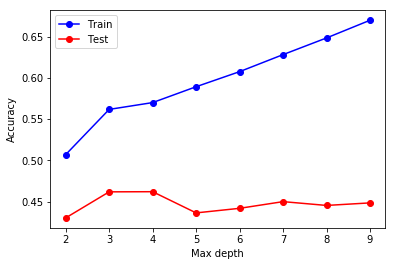

In [228]:

plt.figure()
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()

In [243]:
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=20)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [244]:
# clf.fit(X_train, y_train)
# tree_importance = clf.feature_importances_

In [245]:
aa = pd.DataFrame({'importances':clf.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= False)

# aa.plot.barh(x = 'variables', y='importances', color ='lightsteelblue')#, figsize =(15,5) )
# plt.yticks()#(fontsize = 10)
# plt.tight_layout()
aa[:10]

,importances,variables
82,0.243169,income
76,0.146796,age_of_head
89,0.128311,hh_size_1per
84,0.048896,workers
85,0.038123,county
83,0.036118,persons
88,0.035938,race_of_head
41,0.029512,avg_hhs_1500_walk
3,0.024184,pop_asian_2500_walk
80,0.023760,hh_student


In [246]:
pd.crosstab( y_test.cars_alt, clf.predict(X_test), normalize = 'index')

col_0,0,1,2,3
cars_alt,,,,
0,0.363607,0.423285,0.160821,0.052288
1,0.104430,0.530506,0.276350,0.088714
2,0.030151,0.193725,0.563924,0.212200
3,0.018342,0.097485,0.388009,0.496163


In [247]:
clf.score(X_test, y_test)

0.520348231542162

## Random Forest

In [116]:
from sklearn.ensemble import RandomForestClassifier

In [117]:
clf = RandomForestClassifier(n_estimators=100,criterion='entropy',max_depth=20)
scores = cross_validate(clf, X_train, y_train.cars_alt, cv=3, return_train_score=True)
scores

{'fit_time': array([38.94936776, 38.15188956, 41.07851458]),
 'score_time': array([0.65718699, 0.61905003, 0.57831907]),
 'test_score': array([0.5617013 , 0.52985137, 0.52904731]),
 'train_score': array([0.64631605, 0.6767145 , 0.66101318])}

In [249]:
clf = RandomForestClassifier(n_estimators=100,criterion='entropy',max_depth=20)
clf.fit(X_train, y_train)

aa = pd.DataFrame({'importances':clf.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= False)

# aa.plot.barh(x = 'variables', y='importances', color ='lightsteelblue')#, figsize =(15,5) )
# plt.yticks()#(fontsize = 10)
# plt.tight_layout()
aa[:10]

/home/juan/anaconda3/envs/template-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


,importances,variables
82,0.120489,income
83,0.090636,persons
76,0.079864,age_of_head
84,0.067495,workers
89,0.047126,hh_size_1per
80,0.022490,hh_student
88,0.020814,race_of_head
77,0.016480,children
78,0.014701,hh_16_younger
41,0.014346,avg_hhs_1500_walk


In [250]:
pd.crosstab( y_test.cars_alt, clf.predict(X_test), normalize = 'index')

col_0,0,1,2,3
cars_alt,,,,
0,0.344716,0.496287,0.129638,0.029358
1,0.049443,0.641886,0.266501,0.042170
2,0.006481,0.166692,0.691928,0.134899
3,0.002885,0.060839,0.431088,0.505188


In [251]:
clf.score(X_test, y_test)

0.6019685367863725

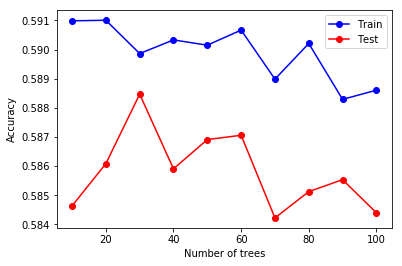

In [125]:
result_train_rf = []
result_test_rf = []
tree_num = range(10,102,10)
for i in tree_num:
    clf = RandomForestClassifier(n_estimators=i,criterion='entropy',max_depth=5)
    scores = cross_validate(clf, X_train, y_train.cars_alt, cv=3, return_train_score=True)
    result_train_rf.append(scores['train_score'].mean())
    result_test_rf.append(scores['test_score'].mean()) 

plt.figure()
plt.plot(tree_num, result_train_rf, '-o',color='blue',label='Train')
plt.plot(tree_num, result_test_rf, '-o',color='red',label='Test')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.legend()

<IPython.core.display.Javascript object>


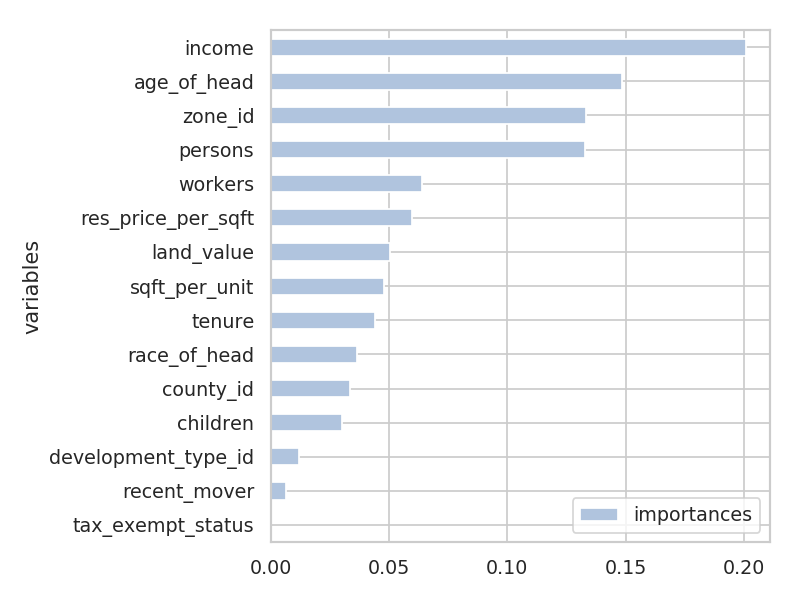

In [178]:
clf_rf = RandomForestClassifier(criterion='entropy',max_depth=30, n_estimators=50)
# scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
# print (scores)

clf_rf.fit(X_train, y_train)

aa = pd.DataFrame({'importances':clf_rf.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= True)

aa.plot.barh(x = 'variables', y='importances', color ='lightsteelblue')#, figsize =(15,5) )
plt.yticks()#(fontsize = 10)
plt.tight_layout()


In [179]:
pd.crosstab( y_test, clf_rf.predict(X_test),normalize = 'index')

col_0,0,1,2,3
cars_alt,,,,
0,0.861206,0.113906,0.019540,0.005348
1,0.011591,0.945425,0.038812,0.004173
2,0.001643,0.040070,0.942567,0.015720
3,0.000787,0.016385,0.098023,0.884805


In [180]:
clf_rf.score(X_test, y_test)

0.9226607027788842

## Nueral network

In [ ]:
from sklearn.neural_network import MLPClassifier